In [2]:
import sys

import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import stats
import qp

sys.path.append("/Users/eleni/Desktop/pymaxent/")
from pymaxent import *

In [25]:
def reconstruct_from_moments(p, x, N):
    
    bnd_low = min(x)
    bnd_high = max(x)

    moments = np.zeros(N)

    for i in range(N):
        moments[i] = np.sum(x**i*p)/((bnd_high-bnd_low)/len(x))**(-1)
    
    sol, lambdas = reconstruct(moments, bnds=[bnd_low, bnd_high])

    return x, sol(x)

In [2]:
with h5py.File("nz_qp_lens.h5", "r") as f:
    Z_MID = f['Z_MID'][::]
    nz_0 = f['nz_0'][::]
    nz_1 = f['nz_1'][::]
    nz_2 = f['nz_2'][::]
    nz_3 = f['nz_3'][::]
    nz_4 = f['nz_4'][::]

In this notebook we want to reconstruct photometric redshift PDFs from known moments. The goal is to demonstrate the use of the pymaxent [1] algorithm on DESC n(z)'s and assess advantages and potential limitations of this method in reconstructing n(z)'s from their moments. As an infinite number of distributions can produce the same finite number of moments, the algorithm uses the principle of maximum entropy to obtain a closed set of equations to solve. This principle states that the less informative statistical process, i.e. the one with the higher entropy is the one the most likely to yield the desired moments among an infinite set of plausible processes.

* Step 1: Simple demonstration on a Gaussian to make sure that 3 moments are sufficient to reconstruct it.
* Step 2: Demonstrate application on DESC n(z)
* Step 3: Assess similarity between target distribution and reconstructed PDF (following [2])
* Step 4: Test on multimodal distributions
* Step 5: Assess performance on DESC n(z)'s as a function of moments

[1] https://www.sciencedirect.com/science/article/pii/S2352711019302456 <br>
[2] https://github.com/aimalz/qtc2021/blob/main/intro.ipynb

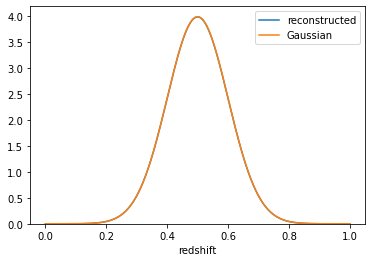

In [68]:
# Step 1

N = 3 # number of moments

x_grid = np.linspace(0., 1., 1000)
p_norm = stats.norm.pdf(x_grid, loc=0.5, scale=0.1)
    
x, sol = reconstruct_from_moments(p_norm, x_grid, N)

plt.plot(x, sol, label = 'reconstructed')
plt.plot(x_grid, p_norm, label = 'Gaussian')
plt.legend()
plt.xlabel("redshift")
plt.ylim(0, )
plt.show()

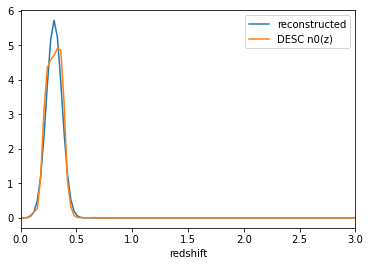

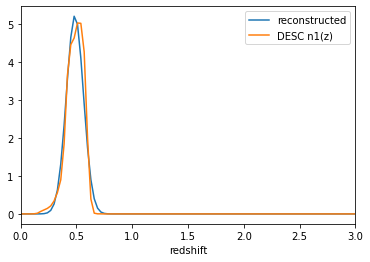

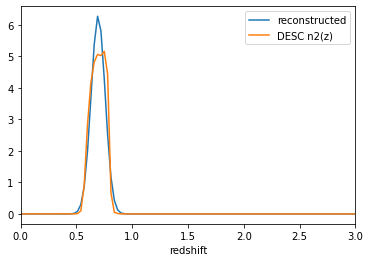

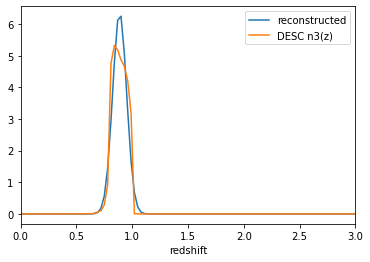

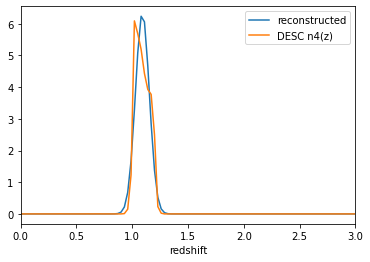

In [10]:
# Step 2

x, sol0 = reconstruct_from_moments(nz_0, Z_MID, 3)

plt.plot(x, sol0, label = 'reconstructed')
plt.plot(Z_MID, nz_0, label = 'DESC n0(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol1 = reconstruct_from_moments(nz_1, Z_MID, 3)

plt.plot(x, sol1, label = 'reconstructed')
plt.plot(Z_MID, nz_1, label = 'DESC n1(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol2 = reconstruct_from_moments(nz_2, Z_MID, 3)

plt.plot(x, sol2, label = 'reconstructed')
plt.plot(Z_MID, nz_2, label = 'DESC n2(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol3 = reconstruct_from_moments(nz_3, Z_MID, 3)

plt.plot(x, sol3, label = 'reconstructed')
plt.plot(Z_MID, nz_3, label = 'DESC n3(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol4 = reconstruct_from_moments(nz_4, Z_MID, 3)

plt.plot(x, sol4, label = 'reconstructed')
plt.plot(Z_MID, nz_4, label = 'DESC n4(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

21.60501089652512 11.069584788910795


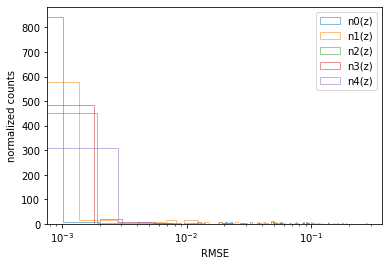

In [51]:
# Step 3

# KL divergence 

from scipy.special import rel_entr

# Draw samples from the DESC and reconstructed distributions to avoid infinity

sample_nz0 = np.random.choice(Z_MID, p = nz_0 / np.sum(nz_0), size = 1000)
sample_sol0 = np.random.choice(Z_MID, p = sol0 / np.sum(sol0), size = 1000)

print(sum(rel_entr(sample_nz0, sample_sol0)), sum(rel_entr(sample_sol0, sample_nz0)))

# RMSE

RMSE0 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_0, sol0)])
RMSE1 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_1, sol1)])
RMSE2 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_2, sol2)])
RMSE3 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_3, sol3)])
RMSE4 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_4, sol4)])

plt.hist(RMSE0, alpha=0.5, bins=100, label='n0(z)', density=True, histtype = "step")
plt.hist(RMSE1, alpha=0.5, bins=100, label='n1(z)', density=True, histtype = "step")
plt.hist(RMSE2, alpha=0.5, bins=100, label='n2(z)', density=True, histtype = "step")
plt.hist(RMSE3, alpha=0.5, bins=100, label='n3(z)', density=True, histtype = "step")
plt.hist(RMSE4, alpha=0.5, bins=100, label='n4(z)', density=True, histtype = "step")
plt.xlabel('RMSE')
plt.xscale("log")
plt.ylabel("normalized counts")
plt.legend()
plt.show()

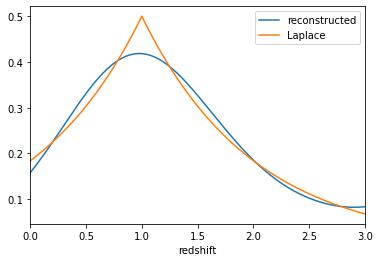

In [54]:
# Step 4

xgrid = np.linspace(0, 3, 1000)

# E.g. the Laplace distribution has 5 moments and all of them are well-defined. 

p_laplace = stats.laplace.pdf(xgrid, 1)

x_laplace, sol_laplace = reconstruct_from_moments(p_laplace, xgrid, 5)

plt.plot(x_laplace, sol_laplace, label = 'reconstructed')
plt.plot(xgrid, p_laplace, label = 'Laplace')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

/Users/eleni/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


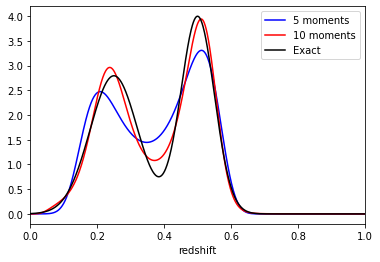

In [27]:
# E.g a bimodal distribution, such as a mixture Gaussian. Example from the paper, Fig. 2.

xgrid = np.linspace(0, 1, 1000)

p_mixture = 0.5 * stats.norm.pdf(xgrid, 0.25, 1/14) + 0.5 * stats.norm.pdf(xgrid, 0.5, 1/20)
norm = np.trapz(p_mixture, xgrid)
p_mixture /= norm

x_mixture, sol_mixture_1 = reconstruct_from_moments(p_mixture, xgrid, 5)
x_mixture, sol_mixture_2 = reconstruct_from_moments(p_mixture, xgrid, 10)

plt.plot(x_mixture, sol_mixture_1, label = '5 moments', c='blue')
plt.plot(x_mixture, sol_mixture_2, label = '10 moments', c='red')
plt.plot(xgrid, p_mixture, label = 'Exact', c='black')
plt.xlim(0, 1)
plt.legend()
plt.xlabel("redshift")
plt.show()

/Users/eleni/Desktop/pymaxent/pymaxent.py:95: RuntimeWarning: overflow encountered in exp
  return x**k * np.exp(np.dot(lamb, xi))
/Users/eleni/Desktop/pymaxent/pymaxent.py:148: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rhs[k] = quad(integrand, a, b, args=(lamb, k))[0] - mu[k]
/Users/eleni/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


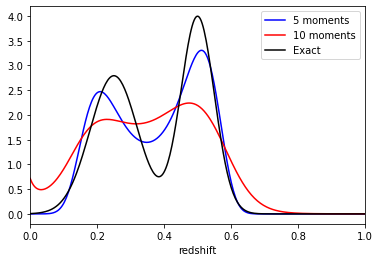

In [28]:
# Now we extend the grid

# E.g a bimodal distribution, such as a mixture Gaussian. Example from the paper, Fig. 2.

xgrid = np.linspace(0, 3, 1000)

p_mixture = 0.5 * stats.norm.pdf(xgrid, 0.25, 1/14) + 0.5 * stats.norm.pdf(xgrid, 0.5, 1/20)
norm = np.trapz(p_mixture, xgrid)
p_mixture /= norm

x_mixture, sol_mixture_1 = reconstruct_from_moments(p_mixture, xgrid, 5)
x_mixture, sol_mixture_2 = reconstruct_from_moments(p_mixture, xgrid, 10)

plt.plot(x_mixture, sol_mixture_1, label = '5 moments', c='blue')
plt.plot(x_mixture, sol_mixture_2, label = '10 moments', c='red')
plt.plot(xgrid, p_mixture, label = 'Exact', c='black')
plt.xlim(0, 1)
plt.legend()
plt.xlabel("redshift")
plt.show()

In [11]:
import jax_cosmo as jc

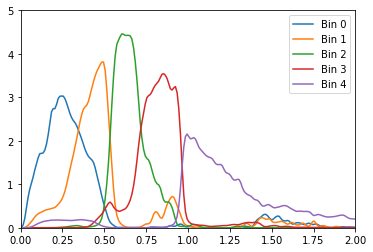

In [36]:
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,  
                                   source[f"bin_{i}"][:], 
                                   bw=0.01, zmax=2.5) for i in range(5)] 
for i in range(5):
    plt.plot(z_shear, nz_shear[i](z_shear), color='C%d'%i, label="Bin %d"%i)
plt.legend()
plt.xlim(0,2)
plt.ylim(0,5)
plt.show()

In [28]:
nz_0 = nz_shear[0](z_shear)
nz_1 = nz_shear[1](z_shear)
nz_2 = nz_shear[2](z_shear)
nz_3 = nz_shear[3](z_shear)
nz_4 = nz_shear[4](z_shear)

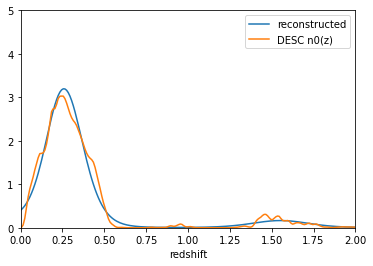

In [57]:
Z_MID = z_shear

x, sol0 = reconstruct_from_moments(nz_0, Z_MID, 9)

plt.plot(x, sol0, label = 'reconstructed')
plt.plot(Z_MID, nz_0, label = 'DESC n0(z)')
plt.xlim(0, 2)
plt.ylim(0, 5)
plt.legend()
plt.xlabel("redshift")
plt.show()


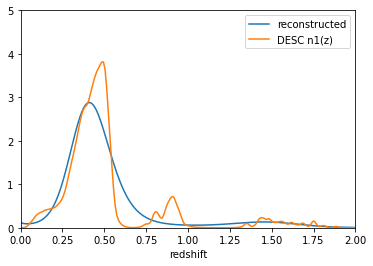

In [79]:
x, sol1 = reconstruct_from_moments(nz_1, Z_MID, 9)

plt.plot(x, sol1, label = 'reconstructed')
plt.plot(Z_MID, nz_1, label = 'DESC n1(z)')
plt.xlim(0, 2)
plt.ylim(0, 5)
plt.legend()
plt.xlabel("redshift")
plt.show()

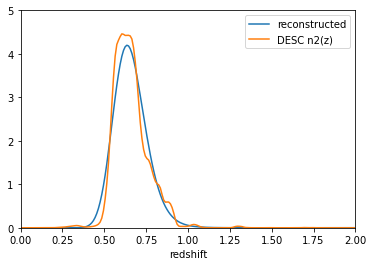

In [89]:
x, sol2 = reconstruct_from_moments(nz_2, Z_MID, 6)

plt.plot(x, sol2, label = 'reconstructed')
plt.plot(Z_MID, nz_2, label = 'DESC n2(z)')
plt.xlim(0, 2)
plt.ylim(0, 5)
plt.legend()
plt.xlabel("redshift")
plt.show()

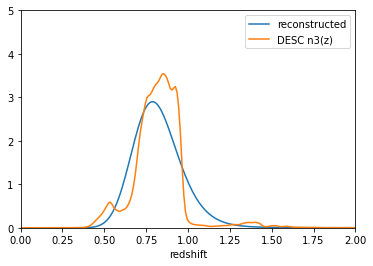

In [103]:
x, sol3 = reconstruct_from_moments(nz_3, Z_MID, 5)

plt.plot(x, sol3, label = 'reconstructed')
plt.plot(Z_MID, nz_3, label = 'DESC n3(z)')
plt.xlim(0, 2)
plt.ylim(0, 5)
plt.legend()
plt.xlabel("redshift")
plt.show()


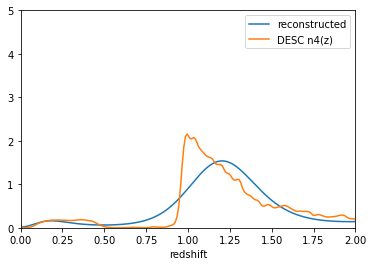

In [108]:
x, sol4 = reconstruct_from_moments(nz_4, Z_MID, 8)

plt.plot(x, sol4, label = 'reconstructed')
plt.plot(Z_MID, nz_4, label = 'DESC n4(z)')
plt.xlim(0, 2)
plt.ylim(0, 5)
plt.legend()
plt.xlabel("redshift")
plt.show()

## Next steps

* Update inference to use moments as parameters
* Explain how we decide the number of moments necessary
* Compare metrics between PDF reconstruction vs shift on mean methods 
* Compare cosmology results using PDF reconstruction vs shift on mean